# Öğrenme Aktarımı (Transfer Learning)

In [1]:
#https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Resizing , Rescaling
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Verinin Olduğu Dosya Yolu
datasetes = "Drug Vision/Data Combined"

### 1) Veri Setinin Yüklenmesi 

In [3]:
image_dir = Path(datasetes)
file_paths = list(image_dir.glob(r"**/*.png")) + list(image_dir.glob(r"**/*.jpg"))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],file_paths))

In [4]:
len(labels)

10000

In [5]:
file_paths = pd.Series(file_paths , name = "filepaths").astype("str")
labels = pd.Series(labels,name="label")
image_df = pd.concat([file_paths,labels] , axis = 1)

In [6]:
image_df.shape

(10000, 2)

### 2)Veri Görselleştirme

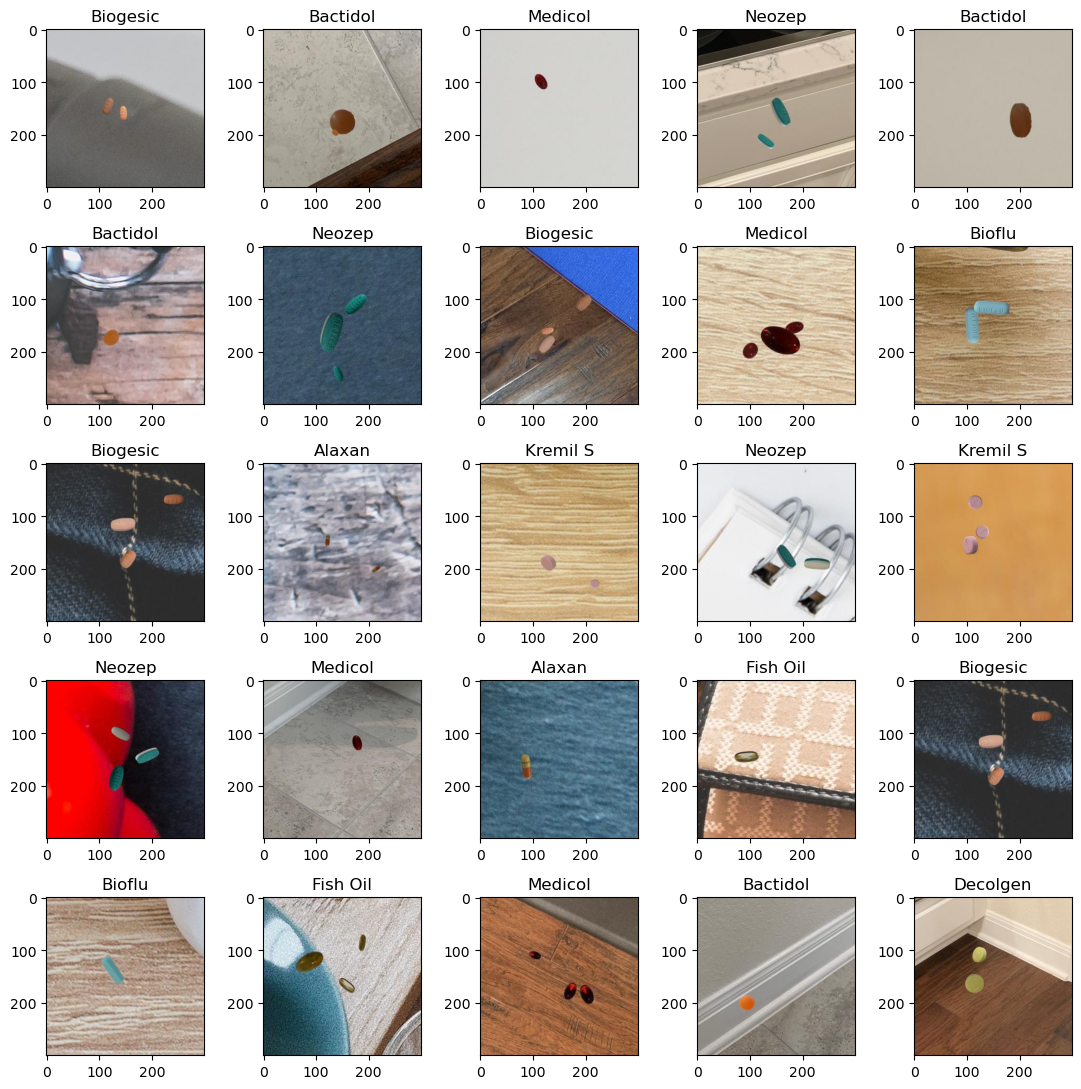

In [7]:
random_index = np.random.randint(0,len(image_df),25)
fig , axes = plt.subplots(nrows = 5 , ncols = 5 , figsize = (11,11))
for i , ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepaths[random_index[i]]))
    ax.set_title(image_df.label[random_index[i]])
plt.tight_layout()
            

### 3) Veri Ön İşleme

In [8]:
train_df , test_df = train_test_split(image_df , test_size = 0.2 , random_state = 42 , shuffle = True ) 

Eğitim Verisini Arttırma

In [9]:
train_generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input , validation_split = 0.2) 

In [10]:
train_images = train_generator.flow_from_dataframe(dataframe = image_df , 
                                                     x_col = "filepaths" ,# Görüntü Yolu
                                                     y_col = "label" , #Hedef Etiket
                                                     target_size = (224,224) , # Görüntülerin hedef boyutu 
                                                     color_mode = "rgb" , # Renkli görüntü modu
                                                     class_mode = "categorical" , # Çoklu sınıf sınıflandırılması
                                                     batch_size = 64 , 
                                                     shuffle = True , # Görüntüleri karıştırma
                                                     seed = 42 ,
                                                     subset = "training" #Eğitim seti
                                                    )

Found 8000 validated image filenames belonging to 10 classes.


In [11]:
image_df.head

<bound method NDFrame.head of                                           filepaths   label
0     Drug Vision\Data Combined\Alaxan\00000000.jpg  Alaxan
1     Drug Vision\Data Combined\Alaxan\00000001.jpg  Alaxan
2     Drug Vision\Data Combined\Alaxan\00000002.jpg  Alaxan
3     Drug Vision\Data Combined\Alaxan\00000003.jpg  Alaxan
4     Drug Vision\Data Combined\Alaxan\00000004.jpg  Alaxan
...                                             ...     ...
9995  Drug Vision\Data Combined\Neozep\00000995.jpg  Neozep
9996  Drug Vision\Data Combined\Neozep\00000996.jpg  Neozep
9997  Drug Vision\Data Combined\Neozep\00000997.jpg  Neozep
9998  Drug Vision\Data Combined\Neozep\00000998.jpg  Neozep
9999  Drug Vision\Data Combined\Neozep\00000999.jpg  Neozep

[10000 rows x 2 columns]>

Validasyon Verisinin arttırımı

In [12]:
val_images = train_generator.flow_from_dataframe(dataframe = image_df , 
                                                     x_col = "filepaths" ,# Görüntü Yolu
                                                     y_col = "label" , #Hedef Etiket
                                                     target_size = (224,224) , # Görüntülerin hedef boyutu 
                                                     color_mode = "rgb" , # Renkli görüntü modu
                                                     class_mode = "categorical" , # Çoklu sınıf sınıflandırılması
                                                     batch_size = 64 , 
                                                     shuffle = True , # Görüntüleri karıştırma
                                                     seed = 42 ,
                                                     subset = "validation" #Eğitim seti
                                                    )

Found 2000 validated image filenames belonging to 10 classes.


Test Verisinin Arttırımı

In [13]:
test_generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)

In [14]:
test_images = test_generator.flow_from_dataframe(dataframe = test_df , 
                                                     x_col = "filepaths" ,# Görüntü Yolu
                                                     y_col = "label" , #Hedef Etiket
                                                     target_size = (224,224) , # Görüntülerin hedef boyutu 
                                                     color_mode = "rgb" , # Renkli görüntü modu
                                                     class_mode = "categorical" , # Çoklu sınıf sınıflandırılması
                                                     batch_size = 64 , 
                                                    )

Found 2000 validated image filenames belonging to 10 classes.


Verinin Normalize Edilmesi

In [15]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(224,224), #Görüntünün boyutlarının belirlenmesi
    Rescaling(1.0/255) # Normalizasyon işlemi
])

### 4)Callback İşlemleri

Önceden Eğitilmiş Model

In [16]:
pretrained_model = MobileNetV2(
                    input_shape = (224,224,3),
                    include_top = False,
                    pooling = "avg",
                    weights = "imagenet" # Eğitilen veri seti
)
pretrained_model.trainable = False # Model eğitilmesin


Callback Fonksiyonları

In [17]:
checkpoint_path = "pharmaceutical_drugs_and_vitamins_classification_checkpoint.weights.h5"
# save_weights_only : Modelin sadece ağrılıklarını kaydet
# save_best_only : Sadece en iyi modeli kaydet  
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only = True , monitor = "val_accuracy" , save_best_only = True )

# 5 Epochs boyunca modelin val_accuracy iyileşme yoksa eğitimi durdur .
early_stopping = EarlyStopping(monitor = "val_accuracy" , patience = 5 , restore_best_weights = True)

### 5)Model İşlemleri

In [18]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = Dense(256 , activation = "relu" )(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256 , activation = "relu" )(x)
x = Dropout(0.2)(x)
outputs = Dense(10,activation = "softmax" )(x)
model = Model(inputs = inputs , outputs = outputs)

Model Compile

In [19]:
model.compile(optimizer = Adam(0.0001), loss = "categorical_crossentropy" , metrics = ["accuracy"])

Training

In [21]:
history = model.fit(train_images , steps_per_epoch = len(train_images) , validation_data = val_images , validation_steps = len(val_images) ,epochs = 10 , callbacks = [checkpoint_callback,early_stopping])

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 873ms/step - accuracy: 0.7040 - loss: 0.8854 - val_accuracy: 0.0000e+00 - val_loss: 7.0199
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 867ms/step - accuracy: 0.7886 - loss: 0.6047 - val_accuracy: 0.0000e+00 - val_loss: 7.7767
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 866ms/step - accuracy: 0.8286 - loss: 0.5026 - val_accuracy: 0.0000e+00 - val_loss: 7.9669
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 868ms/step - accuracy: 0.8503 - loss: 0.4365 - val_accuracy: 0.0000e+00 - val_loss: 8.5459
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 867ms/step - accuracy: 0.8630 - loss: 0.4119 - val_accuracy: 0.0000e+00 - val_loss: 9.0698
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 865ms/step - accuracy: 0.8719 - loss: 0.3633 - val_accuracy: 0.0000e+00 - val_loss: 9.5646


### 6)Model Test İşlemleri

In [22]:
loss , accuracy = model.evaluate(test_images , verbose = 1 )
print(f"Loss :{loss:.4f} Accuracy:{accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 757ms/step - accuracy: 0.6933 - loss: 1.7774
Loss :1.8354 Accuracy:0.6820


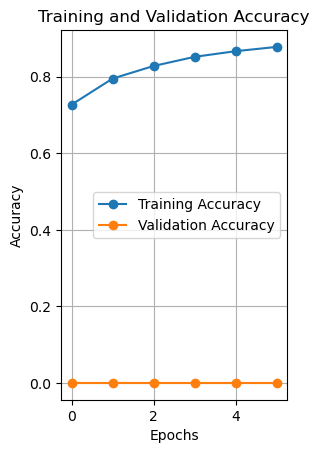

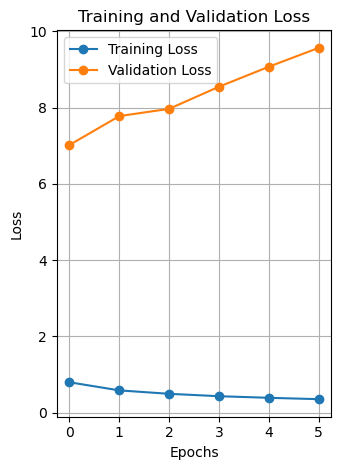

In [25]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"] , marker = "o" , label = "Training Accuracy" )
plt.plot(history.history["val_accuracy"] , marker = "o" , label = "Validation Accuracy" )
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.figure()
plt.subplot(1,2,2)
plt.plot(history.history["loss"] , marker = "o" , label = "Training Loss" )
plt.plot(history.history["val_loss"] , marker = "o" , label = "Validation Loss" )
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Test Görselleştirme

In [31]:
pred = model.predict(test_images )
pred = np.argmax(pred , axis = 1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())



32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 673ms/step


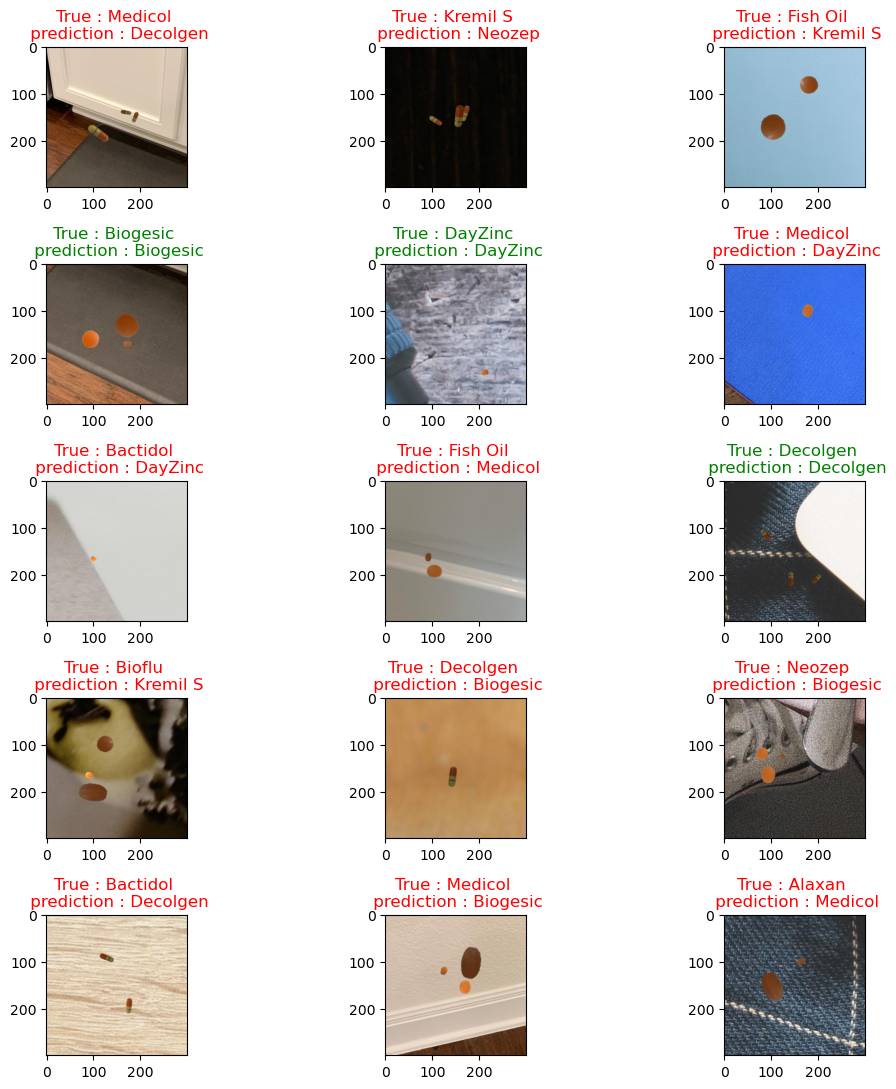

In [32]:
pred = [labels[k] for k in pred]
random_index = np.random.randint(0 , len(test_df) - 1 , 15)
fig , axes = plt.subplots(nrows = 5 , ncols = 3 , figsize = (11,11) )
# color = ""
for i , ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepaths[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]] :
        color = "green"
    else : color = "red"
    ax.set_title(f"True : {test_df.label.iloc[random_index[i]]} \n prediction : {pred[random_index[i]]}" , color = color)
plt.tight_layout()